#**Klasifikasi SMS Penipuan Menggunakan Naive Bayes**

#**Tugas Besar NLP Kelompok Baling-Baling Bambu**
*   Fiqki Haidar Amrulloh
*   Miko Ardian
*   Mohammad Teddy Syamkalla
*   Raafi Alhadi



#**Mount ke drive serta Import & Install Library yang Dibutuhkan**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 15.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import cv2
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import pickle
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#**Dataset Penelitian**

Penjelasan Label 
* 0: SMS normal 
* 1: SMS penipuan 
* 2: SMS promo

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Tugas Besar NLP/1. SMS Classifier - Codingan/dataset_sms_spam.csv')
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,promo


#**Exploratory Data Analysis**

###1. Mengetahui banyaknya jumlah data di setiap label

In [ ]:
print('Total Jumlah SMS:', data.shape[0], 'data')
print('terdiri dari (label):')
print('1. SMS Normal\t:', data[data.label == 'normal'].shape[0], 'data')
print('2. Penipuan\t:', data[data.label == 'penipuan'].shape[0], 'data')
print('3. Promo\t:', data[data.label == 'promo'].shape[0], 'data\n')

Total Jumlah SMS: 1143 data
terdiri dari (label):
1. SMS Normal	: 569 data
2. Penipuan	: 335 data
3. Promo	: 239 data



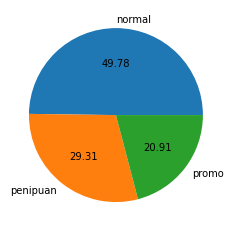

In [ ]:
import matplotlib.pyplot as plt
plt.pie(data['label'].value_counts(), labels=['normal','penipuan', 'promo'],autopct="%0.2f")
plt.show()

###2. Melihat data yang null dan duplicate

In [ ]:
# Nilai null
print("Jumlah data yang null :")
data.isnull().sum()

Jumlah data yang null :


Teks     0
label    0
dtype: int64

In [ ]:
# Melihat data yang duplicate
print("Jumlah data yang duplicate :")
data.duplicated().sum()

Jumlah data yang duplicate :


1

In [ ]:
# Menghapus data yang duplicate
data = data.drop_duplicates(keep='first')

In [ ]:
# Melihat kembali data yang duplicate setelah di remove 
print("Jumlah data yang duplicate :")
data.duplicated().sum()

Jumlah data yang duplicate :


0

In [ ]:
# Bentuk data
print("Adapun bentuk data yaitu :")
data.shape

Adapun bentuk data yaitu :


(1142, 2)

###2. Transform label kedalam bentuk angka & menghitung jumlah karakter

In [ ]:
# Menggunakan label encoder untuk merubah label menjadi 0, 1, 2
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['label'] = encoder.fit_transform(data['label'])
data.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2


In [ ]:
# Menghitung jumlah karakter pada setiap data
data['Jumlah_Karakter'] = data['Teks'].apply(len)
data.head()

,Teks,label,Jumlah_Karakter
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,153
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,152
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,152
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,153
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,113


In [ ]:
# Menghitung jumlah kata pada setiap data
data['Jumlah_Kata'] = data['Teks'].apply(lambda x:len(nltk.word_tokenize(x)))
data.head()

,Teks,label,Jumlah_Karakter,Jumlah_Kata
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,153,32
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,152,34
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,152,29
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,153,29
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,113,25


In [ ]:
# Menghitung jumlah kalimat pada setiap data
data['Jumlah_Kalimat'] = data['Teks'].apply(lambda x:len(nltk.sent_tokenize(x)))
data.head()

,Teks,label,Jumlah_Karakter,Jumlah_Kata,Jumlah_Kalimat
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,153,32,2
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,152,34,4
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,152,29,2
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,153,29,2
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,113,25,3


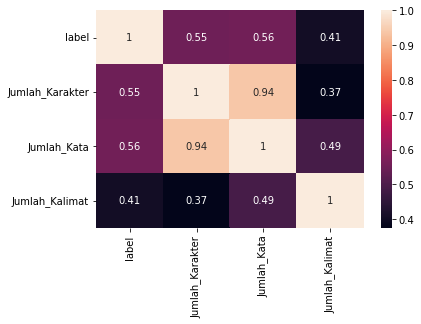

In [ ]:
# Korelasi antar variabel
sns.heatmap(data.corr(),annot=True)

#**Pre-processing**

###1. Case folding

In [ ]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [ ]:
# Membandingkan data sebelum pre-processing dengan yang sudah di pre-processing
raw_sample = data['Teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Data Mentah  : ', raw_sample)
print('Case Folding : ', case_folding)

Data Mentah  :  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case Folding :  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel


###2. Word normalization

In [ ]:
# Menggunakan kamus yang berisi arti dari kata-kata slang
key_norm = pd.read_csv('/content/drive/MyDrive/Tugas Besar NLP/1. SMS Classifier - Codingan/key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [ ]:
# Mengubah kata-kata slang yang ada pada dataset sesuai dengan isi kamus yang disediakan
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

###3. Stopword Removal

In [ ]:
# Menggunakan corpus dari NLTK untuk menghapus stopword
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')
print("Jumlah daftar stopword dari NLTK :")
len(stopwords_ind)

Jumlah daftar stopword dari NLTK :


758

In [ ]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [ ]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['tsel', 'gb', 'rb']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [ ]:
# Membandingkan data sebelum pre-processing dengan yang sudah di pre-processing
raw_sample = data['Teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Data Mentah     : ', raw_sample)
print('Case Folding    : ', case_folding)
print('Stopword Removal: ', stopword_removal)

Data Mentah     :  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case Folding    :  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword Removal:  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel


###4. Stemming

In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [ ]:
# Membandingkan data sebelum pre-processing dengan yang sudah di pre-processing
raw_sample = data['Teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Data Menah       : ', raw_sample)
print('Case Folding     : ', case_folding)
print('Stopword Removal : ', stopword_removal)
print('Stemming         : ', text_stemming)

Data Menah       :  5 HARI LAGI ! EKSTRA Pulsa 50rb dg beli paket internet bulanan di MyTelkomsel utk pembelian pertama sjk 25Aug-25Sept. Cek detail promo di tsel.me/mytsel1
Case Folding     :  hari lagi  ekstra pulsa rb dg beli paket internet bulanan di mytelkomsel utk pembelian pertama sjk augsept cek detail promo di tselmemytsel
Stopword Removal :  ekstra pulsa dg beli paket internet bulanan mytelkomsel utk pembelian sjk augsept cek detail promo tselmemytsel
Stemming         :  ekstra pulsa dg beli paket internet bulan mytelkomsel utk beli sjk augsept cek detail promo tselmemytsel


In [ ]:
# Buat fungsi untuk menggabungkan seluruh langkah text pre-processing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [ ]:
# Hasil semua pre-processing di masukkan kedalam dataset
data['Teks_Bersih'] = data['Teks'].apply(text_preprocessing_process)
data.head()

,Teks,label,Jumlah_Karakter,Jumlah_Kata,Jumlah_Kalimat,Teks_Bersih
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,153,32,2,promo beli paket flash my telkomsel app extra ...
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,152,34,4,rupiah ribu spesial pilih aktif promo sd novem...
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,152,29,2,pulang hormat sisa kuota flash kb download myt...
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,153,29,2,pulang hormat sisa kuota flash kb download myt...
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,113,25,3,rupiah ribu spesial pilih aktif buru skb


In [ ]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal
data.to_csv('clean_data.csv')

In [ ]:
# Memanggil data yang telah bersih
data = pd.read_csv("/content/drive/MyDrive/Tugas Besar NLP/1. SMS Classifier - Codingan/clean_data.csv")
data.head()

,Unnamed: 0,Teks,label,Jumlah_Karakter,Jumlah_Kata,Jumlah_Kalimat,Teks_Bersih
0,0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,2,153,32,2,promo beli paket flash my telkomsel app extra ...
1,1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,2,152,34,4,rupiah ribu spesial pilih aktif promo sd novem...
2,2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",2,152,29,2,pulang hormat sisa kuota flash kb download myt...
3,3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",2,153,29,2,pulang hormat sisa kuota flash kb download myt...
4,4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,2,113,25,3,rupiah ribu spesial pilih aktif buru skb


#**Feature Engineering**

In [ ]:
# Pisahkan kolom fitur dan target
X = data['Teks_Bersih']
y = data['label']

In [ ]:
X

0       promo beli paket flash my telkomsel app extra ...
1       rupiah ribu spesial pilih aktif promo sd novem...
2       pulang hormat sisa kuota flash kb download myt...
3       pulang hormat sisa kuota flash kb download myt...
4                rupiah ribu spesial pilih aktif buru skb
                              ...                        
1137                           yooo oke umumin grup kelas
1138                     nulis kerudung kirain warna jins
1139                                        mbak kirim ya
1140        nama beaok bwrangkat pagimau cas atay tranfer
1141                                       nomor bri nama
Name: Teks_Bersih, Length: 1142, dtype: object

In [ ]:
y

0       2
1       2
2       2
3       2
4       2
       ..
1137    0
1138    0
1139    0
1140    0
1141    0
Name: label, Length: 1142, dtype: int64

In [ ]:
# Melihat data yang null
print("Jumlah nilai null :")
data.isnull().sum()

Jumlah nilai null :


Unnamed: 0         0
Teks               0
label              0
Jumlah_Karakter    0
Jumlah_Kata        0
Jumlah_Kalimat     0
Teks_Bersih        1
dtype: int64

In [ ]:
# Mengisi nilai null dengan other
X = X.fillna(value='other')

###1. Feature extraction (Bag of Words & N-Gram)

In [ ]:
# Proses mengubah teks menjadi vektor menggunakan metode BoW
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [ ]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

3254


In [ ]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Menyimpan objek X_bow dalam format biner dengan nama "bow_feature.pickle"
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

###2. Feature extraction (TF-IDF & N-Gram)

In [ ]:
# Proses mengubah teks menjadi vector menggunakan metode TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [ ]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

3254


In [ ]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aamiiiin,aamiin,ab,abadi,abai,abbee,abdul,acara,acaratks,...,yudisium,yuk,yuks,yuni,yunit,zalora,zarkasi,zjt,zona,ztkm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Menyimpan objek X_tf_idf dalam format biner dengan nama "tf_idf_feature.pickle"
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

###3. Feature selection (Chi Square)

In [ ]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [ ]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Sepuluh fitur dengan statistik chi-kuadrat tertinggi dipilih
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Fitur yang dikurangi
print('Jumlah fitur asli     :', X.shape[1]) 
print('Jumlah fitur berkurang:', X_kbest_features.shape[1]) 

Jumlah fitur asli     : 3254
Jumlah fitur berkurang: 1000


In [ ]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['Nilai'])
data_chi2

,Nilai
0,0.837437
1,0.420397
2,1.560396
3,0.715583
4,0.799700
...,...
3249,1.178971
3250,0.502546
3251,0.715583
3252,2.914228


In [ ]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['Fitur'] = feature
data_chi2

,Nilai,Fitur
0,0.837437,aa
1,0.420397,aamiiiin
2,1.560396,aamiin
3,0.715583,ab
4,0.799700,abadi
...,...,...
3249,1.178971,zalora
3250,0.502546,zarkasi
3251,0.715583,zjt
3252,2.914228,zona


In [ ]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='Nilai', ascending=False)

,Nilai,Fitur
2089,49.000590,paket
1030,46.261599,hadiah
1549,45.540136,kuota
2179,39.383916,pin
1486,34.399053,klik
...,...,...
1520,0.044761,kopi
307,0.044110,bca
1694,0.031685,maksimal
531,0.013274,cepat


In [ ]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False,  True, ..., False,  True, False])

In [ ]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'agam',
 'agen',
 'ags',
 'agst',
 'agsts',
 'agt',
 'agtskinfodlj',
 'agun',
 'agustuskunjungi',
 'ajak',
 'akses',
 'aktif',
 'aktivasi',
 'alam',
 'alamsyah',
 'aliando',
 'all',
 'aman',
 'amanda',
 'an',
 'anda',
 'andabch',
 'andika',
 'andromax',
 'angga',
 'angpaopoinsenyum',
 'angsur',
 'anrasto',
 'ap',
 'apa',
 'aplikasi',
 'app',
 'appleplay',
 'apps',
 'appsinapps',
 'argo',
 'armada',
 'artha',
 'artisartis',
 'arya',
 'as',
 'asa',
 'asli',
 'ass',
 'assalamualaikum',
 'at',
 'atas',
 'ato',
 'aug',
 'augsept',
 'avanza',
 'axiata',
 'axis',
 'axisnet',
 'ayah',
 'ayam',
 'ayo',
 'bagi',
 'baik',
 'bakmi',
 'balas',
 'ball',
 'bandung',
 'bandungmulai',
 'bang',
 'banget',
 'bank',
 'banting',
 'banyak',
 'bapa',
 'bareng',
 'barokahmp',
 'baru',
 'baruqskrng',
 'baskin',
 'batas',
 'batin',
 'bawa',
 'bayar',
 'bb',
 'bbm',
 'bch',
 'bebek',
 'beda',
 'belanja',
 'beli',
 'beliau',
 'belikan',
 'bentar',
 'berangkat',
 'beres',
 'berkat',
 'berlakupromo',
 '

In [ ]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [ ]:
kbest_feature

{'promo': 2296,
 'beli': 323,
 'paket': 2089,
 'flash': 870,
 'my': 1880,
 'telkomsel': 2876,
 'app': 162,
 'extra': 841,
 'kuota': 1549,
 'lte': 1652,
 'telpon': 2879,
 'mnthr': 1831,
 'buru': 480,
 'cek': 521,
 'tselmemytsel': 3014,
 'sk': 2692,
 'rupiah': 2504,
 'ribu': 2453,
 'spesial': 2751,
 'pilih': 2176,
 'aktif': 66,
 'sd': 2558,
 'november': 1989,
 'hormat': 1116,
 'sisa': 2685,
 'kb': 1410,
 'download': 752,
 'mytelkomsel': 1882,
 'apps': 167,
 'kuotabeli': 1550,
 'hubung': 1140,
 'skb': 2693,
 'ekstra': 804,
 'pulsa': 2333,
 'internet': 1220,
 'bulan': 466,
 'sjk': 2691,
 'augsept': 217,
 'detail': 665,
 'iring': 1242,
 'tarif': 2842,
 'panjang': 2102,
 'hits': 1105,
 'armada': 180,
 'curi': 600,
 'tekan': 2870,
 'okcall': 2041,
 'informasi': 1191,
 'eks': 801,
 'loh': 1639,
 'internetan': 1221,
 'pakai': 2087,
 'volume': 3130,
 'ultima': 3067,
 'mbhr': 1738,
 'harga': 1057,
 'tariflokasi': 2844,
 'tselmefl': 3012,
 'jr': 1329,
 'baru': 283,
 'noah': 1964,
 'nya': 2010,
 'h

In [ ]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning
# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,agam,agen,ags,agst,agsts,agt,agtskinfodlj,agun,agustuskunjungi,...,yesok,your,yrkz,ytg,ythmohon,ythsaya,yuk,yunit,zalora,zona
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Menyimpan objek X_kbest_features dalam format biner dengan nama "kbest_feature.pickle"
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

#**Modelling Menggunakan Naive Bayes**

###1. Import library yang diperlukan

In [ ]:
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning yaitu menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

###2. Split dataset kedalam data latih dan data uji

In [ ]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

###3. Fit model menggunakan dataset, setelah itu simpan model

In [ ]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

###4. Test hasil fit model

In [ ]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array([2, 2, 1, 1, 0, 1, 0, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0,
       1, 0, 0, 1, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 2, 0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2,
       0, 0, 1, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 2, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 1, 1, 2, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 1, 0, 1, 0, 2, 0, 0, 2, 1, 2, 0, 0, 1, 0, 1, 0, 2, 0, 1, 2,
       0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2, 0, 1,
       1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 2, 1, 0, 1])

In [ ]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array([0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 0, 2,
       1, 0, 1, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0, 0, 1,
       0, 2, 0, 1, 2, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 2, 0, 1, 2, 0, 0, 2,
       0, 0, 1, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 1, 2, 2, 2, 2, 1, 0, 0, 0,
       2, 0, 1, 0, 2, 1, 0, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 2, 0, 1,
       1, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 2, 0, 0,
       1, 0, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 1, 2,
       0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 2, 1, 0, 1, 2, 0, 2, 1, 1,
       1, 0, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 0, 0, 0, 1, 2, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 2, 1, 0, 1])

#**Model Evaluation**

###1. Melihat jumlah prediksi yang benar

In [ ]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 211
Jumlah prediksi salah	: 18
Akurasi pengujian	: 92.13973799126637 %


###2. Evaluasi model menggunakan matrics accuracy

In [ ]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.96      0.94       110
           1       0.93      0.93      0.93        69
           2       0.93      0.82      0.87        50

    accuracy                           0.92       229
   macro avg       0.92      0.90      0.91       229
weighted avg       0.92      0.92      0.92       229



###3. Evaluasi model menggunakan cross validation

In [ ]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.90829694 0.89082969 0.91703057 0.89082969 0.91266376 0.90829694
 0.93886463 0.88646288 0.90829694 0.93886463] 

Rata-rata akurasi pada cross validation: 0.9100436681222707


###4. Visualisasi

In [ ]:
# Melihat kata-kata yang paling banyak digunakan sesuai dengan label
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

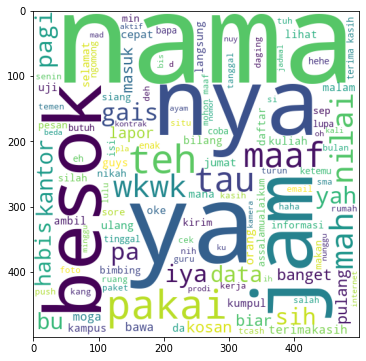

In [ ]:
# Kata yang paling banyak digunakan pada SMS Normal
SMS_Normal = wc.generate(data[data['label'] == 0]['Teks_Bersih'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(SMS_Normal)

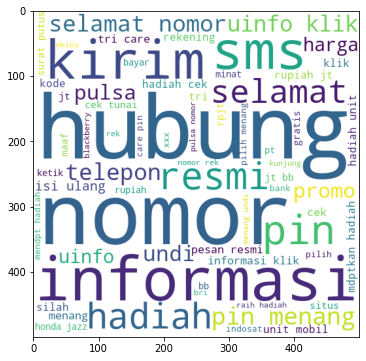

In [ ]:
# Kata yang paling banyak digunakan pada SMS Penipuan
SMS_Penipuan = wc.generate(data[data['label'] == 1]['Teks_Bersih'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(SMS_Penipuan)

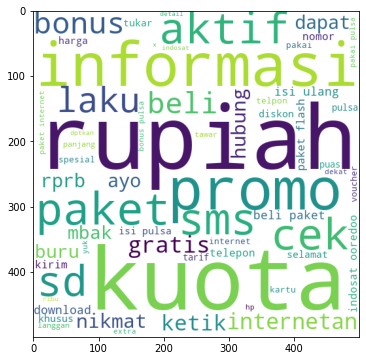

In [ ]:
# Kata yang paling banyak digunakan pada SMS Promo
SMS_Promo = wc.generate(data[data['label'] == 2]['Teks_Bersih'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(SMS_Promo)

In [ ]:
from joblib import load

# load model
model = load('/content/drive/MyDrive/Tugas Besar NLP/1. SMS Classifier - Codingan/model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('/content/drive/MyDrive/Tugas Besar NLP/1. SMS Classifier - Codingan/kbest_feature.pickle', 'rb'))

#**Deployed Sederhana**

In [ ]:
#@title Masukkan Teks Anda:
input_text = "Beli 2 gratis 1" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result==0):
  sms = 'SMS Normal'
elif (result==1):
  sms = 'SMS Penipuan'
else:
  sms = 'SMS Promo'

print('Hasil prediksi', input_text, ' adalah\n', sms)

Hasil Text Preprocessing : beli gratis
Hasil prediksi Beli 2 gratis 1  adalah
 SMS Promo
